# Labwork for Hamiltonian Simulation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.linalg import expm
from tqdm import tqdm
from functools import reduce

import itertools

#### Trotterization

First, we will see the effect of approximating the exponential of some Hamiltonian by the product of exponentials of each individual term, repeated several times, i.e.
$$e^{-iHt} \approx \left(e^{-iH_1 t/n} e^{-iH_2 t/n} \dots e^{-iH_m t/n}\right)^n$$
where $H = \sum_{i=1}^{m} H_i$.

We will simulate this using numpy. First, let us define some helper functions.

In [2]:
idty = np.eye(2)  # Polyoperators
x = np.array([[0,1],
              [1,0]])
y = np.array([[0,-1j],
              [1j,0]])
z = np.array([[1,0],
              [0,-1]])

def pauli_1q(op_str, i, N):
    """
    op_str: operator on i-th qubit, one of 'X', 'Y', 'Z'
    i: index of qubit (0th qubit is rightmost in the register)
    N: total number of qubits
    """
    global idty, x, y, z
    d_str_op = {'X': x, 'Y': y, 'Z': z}
    op_list = [idty]*(N-i-1) + [d_str_op[op_str]] + [idty]*i
    return reduce(np.kron, op_list)

def pauli_2q(op_str_i, op_str_j, i, j, N):
    """
    op_str_i: operator on i-th qubit, one of 'X', 'Y', 'Z'
    op_str_j: operator on j-th qubit, one of 'X', 'Y', 'Z'
    i: index of i-th qubit (0th qubit is rightmost in the register)
    j: index of j-th qubit (0th qubit is rightmost in the register)
    N: total number of qubits
    """
    global idty, x, y, z
    d_str_op = {'X': x, 'Y': y, 'Z': z}
    if i > j:
        op_list = [idty]*(N-i-1) + [d_str_op[op_str_i]] + [idty]*(i-j-1) + [d_str_op[op_str_j]] + [idty]*j
    else:
        op_list = [idty]*(N-j-1) + [d_str_op[op_str_j]] + [idty]*(j-i-1) + [d_str_op[op_str_i]] + [idty]*i
    return reduce(np.kron, op_list)

def commutator(A, B):
    return (A @ B) - (B @ A)

def spectral_norm(A):
    return np.linalg.norm(A, ord=2)

Next, we create a rather simple Hamiltonian $H = X_0 X_1 + Y_0 Y_2 + Z_1 Z_2$, and compute the difference in the norms of the unitaries on either side of the approximation
$$e^{-iHt} \approx \left(e^{-iX_0 X_1 t/n} e^{-i Y_0 Y_2 t/n} e^{-i Z_1 Z_2 t/n}\right)^n$$
for increasingly larger $n$ for a single unit of time $t=1$.

100%|██████████| 30/30 [00:00<00:00, 150.06it/s]


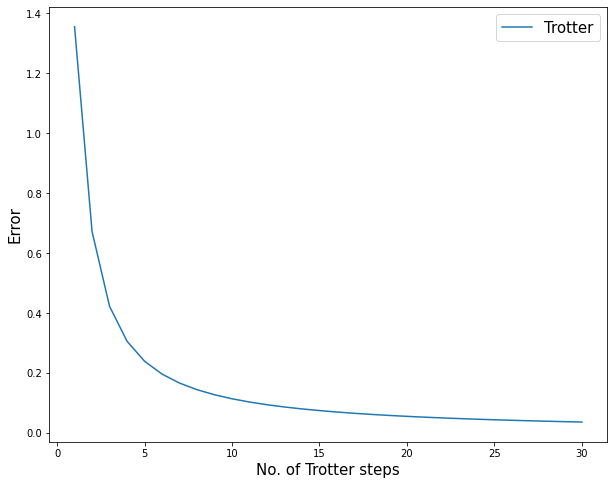

In [3]:
# Create a toy Hamiltonian
ham_term1 = pauli_2q('X', 'X', 0, 1, 3)
ham_term2 = pauli_2q('Y', 'Y', 0, 2, 3)
ham_term3 = pauli_2q('Z', 'Z', 1, 2, 3)
ham = ham_term1 + ham_term2 + ham_term3

t = 1
n_list = list(range(1, 30+1, 1))

exp_ham = expm(-1j*ham*t)
norm_diffs_trotter = []

for n in tqdm(n_list):
    trotter_step = expm(-1j*ham_term1*t/n) @ expm(-1j*ham_term2*t/n) @ expm(-1j*ham_term3*t/n)
    trotter = np.linalg.matrix_power(trotter_step, n)
    diff_trotter = exp_ham - trotter
    norm_diff_trotter = np.abs(spectral_norm(diff_trotter))
    norm_diffs_trotter.append(norm_diff_trotter)
    
# print(min(norm_diffs_trotter))
plt.figure(figsize=(10,8))
plt.plot(n_list, norm_diffs_trotter, label='Trotter')
plt.xlabel('No. of Trotter steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

Exercise: Repeat the same, except now do it with the higher order approximation<br>

$$e^{-iHt} \approx \left( e^{-iX_0 X_1 t/2n} e^{-i Y_0 Y_2 t/2n} e^{-i Z_1 Z_2 t/n}e^{-i Y_0 Y_2 t/2n} e^{-iX_0 X_1 t/2n}\right) $$

for the same value of t and (range of values of) n. Plot the difference in the norms from both approaches, and verify that the higher order expression converges to lower error faster. Let's call this method "Strang" to distinguish it from the (lowest order) "Trotter" method above.

100%|██████████| 30/30 [00:00<00:00, 71.06it/s]


0.037068550437969756
0.0005508690835254466


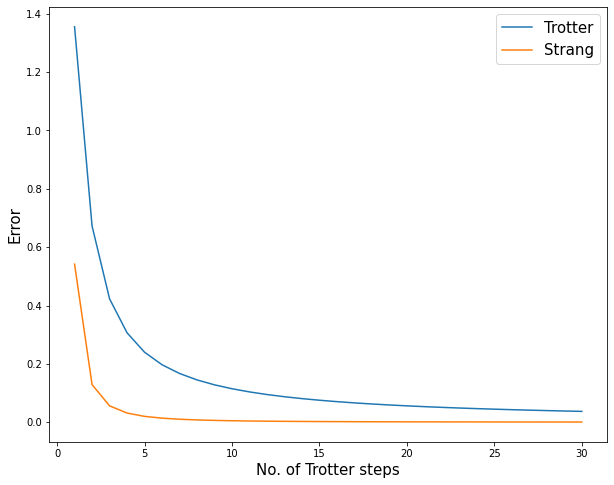

In [5]:
# Create a toy Hamiltonian
ham_term1 = pauli_2q('X', 'X', 0, 1, 3)
ham_term2 = pauli_2q('Y', 'Y', 0, 2, 3)
ham_term3 = pauli_2q('Z', 'Z', 1, 2, 3)
ham = ham_term1 + ham_term2 + ham_term3

t = 1
n_list = list(range(1, 30+1, 1))

exp_ham = expm(-1j*ham*t)
norm_diffs_trotter = []
norm_diffs_strang = []

for n in tqdm(n_list):
    trotter_step = expm(-1j*ham_term1*t/n) @ expm(-1j*ham_term2*t/n) @ expm(-1j*ham_term3*t/n)
    strang_step = expm(-1j*ham_term1*t/(2*n)) @ expm(-1j*ham_term2*t/(2*n)) @ expm(-1j*ham_term3*t/(n)) @ expm(-1j*ham_term2*t/(2*n)) @ expm(-1j*ham_term1*t/(2*n))

    trotter = np.linalg.matrix_power(trotter_step, n)
    strang = np.linalg.matrix_power(strang_step, n)

    diff_trotter = exp_ham - trotter
    diff_strang = exp_ham - strang

    norm_diff_trotter = np.abs(spectral_norm(diff_trotter))
    norm_diff_strang = np.abs(spectral_norm(diff_strang))

    norm_diffs_trotter.append(norm_diff_trotter)
    norm_diffs_strang.append(norm_diff_strang)
    
print(min(norm_diffs_trotter))
print(min(norm_diffs_strang))
plt.figure(figsize=(10,8))
plt.plot(n_list, norm_diffs_trotter, label='Trotter')
plt.plot(n_list, norm_diffs_strang, label='Strang')
plt.xlabel('No. of Trotter steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

#### LCU

Next, we will explore sub-routines in the Linear Combination of Unitaries (LCU) and Qubitization methods. For this section, you will need pyQuil, so be sure to install it (https://pyquil-docs.rigetti.com/en/stable/start.html) if you haven't already.

In [7]:
!pip install pyquil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 220 kB 5.1 MB/s 
     |████████████████████████████████| 229 kB 33.9 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 142 kB 42.1 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 243 kB 36.1 MB/s 
     |████████████████████████████████| 1.6 MB 43.8 MB/s 
     |████████████████████████████████| 109 kB 37.9 MB/s 
     |████████████████████████████████| 546 kB 54.9 MB/s 
  Created wheel for lark: filename=lark-0.11.3-py2.py3-none-any.whl size=99648 sha256=60def9853e1eb6d6ec75079881c145e63baad6ab8499ddae7f0b37bbf8e22fdc
  Stored in directory: /root/.cache/pip/wheels/d7/61/3c/9ac365f55

In [8]:
from pyquil import Program, get_qc
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

Recall that in the linear combination of unitaries (LCU) approach, as well as in qubitization, we require access to the unitary $U_{PREP}$ which acts as
$$U_{PREP} = \sum_{i=1}^{L} \alpha_{i} \vert i \rangle$$
where the Hamiltonian we wish to simulate is $H = \sum_{i} \alpha_i U_i$. W assume that $\alpha_i > 0$ (absorb any phases into the unitaries $U_i$'s), so that we need a general method to prepare a state with some input real amplitudes, which we describe below.

Given a quantum state with real amplitudes, how do we construct a circuit that would prepare such a state? As described in "Transformation of quantum states using uniformly controlled rotations" by Mottonen et al. (https://arxiv.org/pdf/quant-ph/0407010.pdf), we need to run the following series of controlled rotations:
<img src="https://github.com/ntubman/summerschool/blob/main/oldlabs/lab1/Labs/uniformly_controlled_rotations.png?raw=1" alt="Drawing" style="width: 1000px;"/>
where the black dots denote the control qubit being in the state $\vert 1 \rangle$ and the white dots denote the control qubit being in the state $\vert 0 \rangle$.

The angles are to be calculated according to
<img src="https://github.com/ntubman/summerschool/blob/main/oldlabs/lab1/Labs/beta_angles.png?raw=1" alt="Drawing" style="width: 400px;"/>

Let us first write a function that can calculate the $\beta$'s above.

In [ ]:
def all_betas(amps):
    """
    Given some real amplitudes, compute the RY angles needed to prepare this state

    :return dict: key: (s, j), value: beta angle
    """
    n = math.log(len(amps), 2)
    assert np.isclose(n, int(n)), "Specify 2^n amplitudes for some n"
    n = int(n)
    d_betas = {}
    for s in range(1, n + 1):
        for j in range(1, 2**(n-s) + 1):
            # calculate numerator
            ### TODO
            # calculate denominator
            ### TODO
            # avoid any pathological cases, e.g. if denominator = 0.0
            if np.isclose(numerator, 0.0):
                ratio = 0.0
            else:
                ratio = numerator / denominator
            # ensure argument to arccos lies within domain [-1, 1]
            if ratio > 1.0:
                ratio = 1.0
            elif ratio < -1.0:
                ratio = -1.0
            else:
                pass
            # finally, compute the beta angles
            d_betas[s, j] = -2 * np.arcsin(ratio)
    return d_betas

Following this, we now write a function that will encode a given classical vector into the amplitudes of a quantum state. For example, for a circuit that produces an equal superposition of 3-qubit states with amplitudes $1/\sqrt{2^3}$, this would produce the following output (py)Quil program (even though for this simple case, we can simply perform Hadamards on all the qubits):<br>
<br>
RY(-1.5707963267948968) 2<br>
CONTROLLED RY(-1.5707963267948963) 2 1<br>
X 2<br>
CONTROLLED RY(-1.5707963267948963) 2 1<br>
X 2<br>
CONTROLLED CONTROLLED RY(-1.5707963267948968) 2 1 0<br>
X 1<br>
CONTROLLED CONTROLLED RY(-1.5707963267948968) 2 1 0<br>
X 1<br>
X 2<br>
CONTROLLED CONTROLLED RY(-1.5707963267948968) 2 1 0<br>
X 2<br>
X 1<br>
X 2<br>
CONTROLLED CONTROLLED RY(-1.5707963267948968) 2 1 0<br>
X 2<br>
X 1<br>

In [ ]:
def state_prep_prog(amps):
    """
    Given some real amplitudes, compute the pyQuil Program needed to prepare this state
    
    :return Program: state preparation circuit
    """
    n = math.log(len(amps), 2)
    assert np.isclose(n, int(n)), "Specify 2^n amplitudes for some n"
    n = int(n)
    d_betas = all_betas(amps)
    tot_prog = Program()
    for s in range(n, 0, -1):
        tot_js = 2**(n-s)
        num_combs = math.log(tot_js, 2)
        assert np.isclose(num_combs, int(num_combs)), "Something went wrong"
        num_combs = int(num_combs)
        all_combs = np.array(list(itertools.product([0, 1], repeat=num_combs)))
        for j in range(1, tot_js + 1)[::-1]:
            if len(all_combs) == 1:
                tot_prog += Program(f"RY({d_betas[s, j]}) {s-1}")
            else:
                # pick the relevant combination, e.g. [0,0] or [0, 1] or [1, 0] or [1, 1] for two control qubits
                comb = all_combs[j-1]
                rot_oper_prog_str = f"RY({d_betas[s, j]}) "
                rot_qub_prog_str = f"{s-1}"
                flip_prog_strs = []
                # this loops through the controlled operation, e.g. [0, 1] in the opposite direction
                for x, cbit in enumerate(comb[::-1]):
                    if cbit == 0:
                        flip_prog_strs += [f"X {s+x}"]
                    else:
                        pass
                    rot_oper_prog_str = # TODO
                    rot_qub_prog_str = # TODO
                rot_prog_str = rot_oper_prog_str + rot_qub_prog_str
                tot_prog += Program(flip_prog_strs) + Program(rot_prog_str) + Program(flip_prog_strs[::-1])

    return tot_prog

To check the correctness of our implementation, we will test the functions above against random amplitudes.

In [ ]:
wfn_sim = WavefunctionSimulator()

In [ ]:
def random_amplitudes(num_qubits=3):
    N = 2**num_qubits
    amps = np.random.uniform(low=0.0, high=1.0, size=N)
    amps *= 1 / np.sqrt(np.sum(np.abs(amps)**2))
    assert np.isclose(np.sum(np.abs(amps)**2), 1.0), "Amplitudes do not square-sum to 1"
    return amps

In [ ]:
n_trials = 100

for _ in tqdm(range(n_trials)):

    # draw some random real amplitudes
    amps = random_amplitudes()

    # create the state prep Program corresponding to these amplitudes
    prep_prog = state_prep_prog(amps)
    wfn = wfn_sim.wavefunction(prep_prog)

    # compare the outcome probabilities resulting from the state prep Program
    # with the expected probabilities
    outcome_probs = list(wfn.get_outcome_probs().values())
    expected_probs = amps**2
    assert np.allclose(expected_probs, outcome_probs), "Measurement probabilities do not agree"